# Bi Pipeline Hackathon
## Track UAV - Fault Detection and Preventive Maintenance of Drones

##### Alexis DUCROUX, Ryan JABBOUR, Terence FERNANDES, Charles POUTE DE PUYBAUDET, Arthur	PUISSILIEUX, Lucas MIAKINEN


---

# Préparation et méthodes de chargement et conversion des données

In [1]:
from __future__ import annotations
import os
from typing import Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd


def _try_load_mat(path: str) -> Tuple[str, Any]:
    """Charge un .mat avec scipy (v5/v7) ou h5py (v7.3 HDF5).

    Retourne (backend, objet):
      - backend == "scipy" -> objet est le dict loadmat
      - backend == "h5py"  -> objet est un h5py.File ouvert
    """
    # Tentative SciPy (v5/v7)
    try:
        from scipy.io import loadmat
        data = loadmat(path, struct_as_record=False, squeeze_me=True)
        return "scipy", data
    except Exception:
        pass

    # Fallback HDF5 (v7.3)
    try:
        import h5py
        f = h5py.File(path, "r")
        return "h5py", f
    except Exception as e:
        raise RuntimeError(f"Impossible de lire le fichier .mat: {e}")


def _collect_arrays_from_scipy(matdict: Dict[str, Any]) -> Dict[str, np.ndarray]:
    """Extrait les tableaux numériques d'un dict renvoyé par scipy.io.loadmat."""
    ignore = {"__header__", "__version__", "__globals__"}
    out: Dict[str, np.ndarray] = {}
    for k, v in matdict.items():
        if k in ignore:
            continue
        if isinstance(v, np.ndarray) and v.size > 0 and np.issubdtype(v.dtype, np.number):
            out[k] = np.asarray(v)
        # Gestion des scalaires numériques (float/int MATLAB)
        elif np.isscalar(v) and isinstance(v, (int, float, np.integer, np.floating)):
            out[k] = np.asarray([v])
    return out


def _collect_arrays_from_h5(path: str, h5file: Any) -> Dict[str, np.ndarray]:
    """Extrait les datasets numériques d'un fichier HDF5 (MAT v7.3)."""
    import h5py

    arrays: Dict[str, np.ndarray] = {}

    def visit(name: str, obj: Any):
        if isinstance(obj, h5py.Dataset):
            try:
                arr = obj[()]
                # h5py renvoie souvent des types HDF5 → convertir en numpy
                arr = np.asarray(arr)
                if arr.size > 0 and np.issubdtype(arr.dtype, np.number):
                    # Normaliser le nom pour DataFrame (éviter les "/")
                    key = name.replace("/", "_")
                    arrays[key] = arr
            except Exception:
                pass

    h5file.visititems(visit)
    return arrays


def _expand_columns(name: str, arr: np.ndarray) -> Dict[str, np.ndarray]:
    """Crée un mapping nom_colonne -> vecteur 1D pour un tableau numpy.

    - 1D: {name: arr}
    - 2D: {f"{name}_c0": col0, ...}
    - >2D: aplatissement (chaque index supplémentaire devient un suffixe)
    """
    arr = np.asarray(arr)
    result: Dict[str, np.ndarray] = {}

    if arr.ndim == 1:
        result[name] = arr
        return result

    if arr.ndim == 2:
        n_rows, n_cols = arr.shape
        for i in range(n_cols):
            result[f"{name}_c{i}"] = arr[:, i]
        return result

    # >2D: on aplatit en colonnes par combinaison d'indices après le premier axe
    # shape = (N, d1, d2, ...)
    n = arr.shape[0]
    tail = arr.reshape(n, -1)
    for i in range(tail.shape[1]):
        result[f"{name}_c{i}"] = tail[:, i]
    return result


def _choose_length(arrays: Dict[str, np.ndarray]) -> int:
    """Choisit une longueur d'échantillons cible (N) cohérente pour bâtir le DataFrame.

    Stratégie: prend la longueur la plus fréquente (>1) ou la plus grande.
    """
    lengths: Dict[int, int] = {}
    for a in arrays.values():
        a = np.asarray(a)
        n = a.shape[0] if a.ndim >= 1 else 1
        lengths[n] = lengths.get(n, 0) + 1
    # Retire N==1 (scalaires)
    lengths = {k: v for k, v in lengths.items() if k > 1}
    if not lengths:
        # Aucun vecteur/ligne: retourner 1 pour construire quand même (métadonnées)
        return 1
    # Choix: longueur la plus fréquente, sinon la plus grande
    best = max(lengths.items(), key=lambda kv: (kv[1], kv[0]))[0]
    return best


def _candidate_target_keys() -> Tuple[str, ...]:
    return ("label", "target", "y", "class")


def _candidate_feature_keys() -> Tuple[str, ...]:
    # Quelques clés courantes pour séries temporelles/trajectoires capteurs
    return (
        "data", "X", "features", "signal", "signals", "trajectory",
        "acc", "gyro", "mag", "pos", "vel",
        "x", "y", "z", "ax", "ay", "az", "gx", "gy", "gz"
    )


def _build_dataframe(arrays: Dict[str, np.ndarray]) -> pd.DataFrame:
    """Construit un DataFrame prêt pour le ML à partir d'un mapping {var -> np.ndarray}.

    - Détecte un éventuel vecteur cible si présent (label/target/y/class) de longueur N.
    - Concatène toutes les variables de longueur N comme features (en expandant les 2D en colonnes).
    - Les scalaires (N=1) sont ignorés pour X mais peuvent être conservés ensuite si besoin.
    """
    if not arrays:
        raise ValueError("Aucune variable numérique trouvée dans le .mat")

    # Détermine N
    N = _choose_length(arrays)

    # Détecte une cible
    target_key: Optional[str] = None
    for k in _candidate_target_keys():
        if k in arrays:
            a = np.asarray(arrays[k])
            if a.ndim >= 1 and a.shape[0] == N:
                target_key = k
                break

    columns: Dict[str, np.ndarray] = {}

    # D'abord, colonnes candidates explicites (features communes)
    explicit = [k for k in arrays.keys() if k in _candidate_feature_keys()]

    def add_if_match(name: str, a: np.ndarray):
        a = np.asarray(a)
        if a.ndim == 0:
            return
        if a.shape[0] != N:
            return
        for col_name, col_values in _expand_columns(name, a).items():
            columns[col_name] = np.asarray(col_values).reshape(-1)

    # Ajout des features explicites
    for k in explicit:
        if k == target_key:
            continue
        add_if_match(k, arrays[k])

    # Ajout des autres variables compatibles (hors cible)
    for k, v in arrays.items():
        if k == target_key or k in explicit:
            continue
        add_if_match(k, v)

    # Ajout éventuel de la cible
    if target_key is not None:
        y = np.asarray(arrays[target_key]).reshape(-1)
        columns[target_key] = y

    if not columns:
        # Dernier recours: prendre la plus grande matrice 2D et en faire un DF
        biggest_key = None
        biggest_size = -1
        for k, v in arrays.items():
            v = np.asarray(v)
            size = v.size
            if size > biggest_size and v.ndim >= 1:
                biggest_key = k
                biggest_size = size
        if biggest_key is not None:
            return pd.DataFrame(_expand_columns(biggest_key, np.asarray(arrays[biggest_key])))
        raise ValueError("Impossible de construire un DataFrame cohérent à partir des variables disponibles")

    return pd.DataFrame(columns)


def load_dataset(dataset_name: str, directory: str = "dataset") -> pd.DataFrame:
    """Charge un fichier .mat par nom et retourne un DataFrame prêt pour le ML.

    Paramètres
    ----------
    dataset_name : str
        Nom du dataset (ex: "F1_SV1_SP1_t1" ou chemin complet). L'extension .mat
        est ajoutée automatiquement si absente.
    directory : str
        Répertoire contenant les .mat si `dataset_name` n'est pas un chemin.

    Retour
    ------
    pd.DataFrame
        Un tableau où chaque colonne est une feature; s'il existe une cible
        (label/target/y/class) alignée, elle est incluse comme colonne.

    Notes
    -----
    - Gère les .mat MATLAB v5/v7 (scipy.io.loadmat) et v7.3 (HDF5 via h5py).
    - Heuristiques pour détecter X et y, adaptées aux séries temporelles capteurs.
    """
    # Résout le chemin du fichier
    candidate = dataset_name
    if not os.path.isabs(candidate):
        candidate = os.path.join(directory, candidate)
    if not candidate.lower().endswith(".mat"):
        candidate_mat = candidate + ".mat"
        path = candidate_mat if os.path.exists(candidate_mat) else candidate
    else:
        path = candidate

    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier .mat introuvable: {path}")

    backend, obj = _try_load_mat(path)

    if backend == "scipy":
        arrays = _collect_arrays_from_scipy(obj)
    else:  # h5py
        arrays = _collect_arrays_from_h5(path, obj)

    df = _build_dataframe(arrays)

    # Ferme le fichier HDF5 si ouvert
    try:
        import h5py  # type: ignore
        if backend == "h5py" and isinstance(obj, h5py.File):
            obj.close()
    except Exception:
        pass

    return df


In [2]:
# Exemple d'utilisation (décommentez pour tester dans le notebook)
df = load_dataset("F1_SV1_SP1_t1.mat")
df.head()

,QDrone_data_c0,QDrone_data_c1,QDrone_data_c2,QDrone_data_c3,QDrone_data_c4,QDrone_data_c5,QDrone_data_c6,QDrone_data_c7,QDrone_data_c8,QDrone_data_c9,...,QDrone_data_c89448,QDrone_data_c89449,QDrone_data_c89450,QDrone_data_c89451,QDrone_data_c89452,QDrone_data_c89453,QDrone_data_c89454,QDrone_data_c89455,QDrone_data_c89456,QDrone_data_c89457
0,0.000000,0.001000,0.002000,0.003000,0.004000,0.005000,0.006000,0.007000,0.008000,0.009000,...,89.449000,89.450000,89.451000,89.452000,89.453000,89.454000,89.455000,89.456000,89.457000,89.458000
1,0.000000,-0.000006,-0.000002,-0.000007,-0.000012,-0.000017,-0.000023,-0.000026,-0.000029,-0.000033,...,-0.020446,-0.020405,-0.020384,-0.020373,-0.020358,-0.020355,-0.020380,-0.020410,-0.020467,-0.020530
2,0.000000,0.000011,0.000008,0.000019,0.000030,0.000040,0.000055,0.000065,0.000075,0.000086,...,0.001687,0.001997,0.002305,0.002614,0.002879,0.003117,0.003338,0.003568,0.003767,0.003958
3,0.000000,0.000009,0.000096,0.000117,0.000138,0.000159,0.000168,0.000212,0.000256,0.000299,...,2.947099,2.947088,2.947072,2.947056,2.947044,2.947031,2.947025,2.947020,2.947019,2.947019
4,-0.002397,-0.002397,-0.002397,-0.002266,-0.002156,-0.002062,-0.001983,-0.001939,-0.001877,-0.001802,...,-0.086484,-0.085463,-0.084740,-0.084218,-0.083858,-0.083498,-0.083142,-0.083077,-0.083237,-0.083979


### Table 1. Data files naming rules.

| **Code** | **Possible values**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| -------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **F**    | `{1,2,3}`, where **F#n**: Fault group #n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| **SV**   | `{1,2,3}`, where **SV#n**: Severity level #n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| **SP**   | `{1,2}`, where **SP#n**: Speed #n  <br> **SP1**: Maximum Speed of (2 m/s, 3.14 rad/s) <br> **SP2**: Maximum Speed of (0.333 m/s, 0.52 rad/s)                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| **t**    | `{1,2,3,4,5}`, where **t#n**: Trajectory #n  <br> **t1:** *Diagonal motion* (The drone moves back and forth along the diagonals of a 1×1 m square)  <br> **t2:** *Square-shaped motion* (The drone moves along the edges of a 1×1 m square)  <br> **t3:** *Ascending and descending in steps* (The drone altitude increases from 0.2 m to 0.8 m in 0.2 m increments)  <br> **t4:** *Ascending and descending in one shot* (The drone altitude increases from 0.2 m to 0.8 m directly)  <br> **t5:** *Yawing maneuver* (The drone rotates by 45°, −45°, 90°, and −90° independently) |
| **D**    | `{1,2,3}`, where **D#n**: Drone #n  <br> Healthy trajectories are generated for three drones, while faulty trajectories are generated for drone 1 only.                                                                                                                                                                                                                                                                                                                                                                                                                             |
| **R**    | `{1,2,3}`, where **R#n**: Repetition #n  <br> When the same combination of the codes other than “R” is repeated more than once (the same experiment is repeated).                                                                                                                                                                                                                                                                                                                                                                                                                   |


**Examples:**
1. F0_SV0_SP1_t1_D1_R1.mat: a flight log dataset for a fully healthy drone number 1 with a Maximum Speed of (2 m/s, 3.14 rad/s) along Trajectory 1.

2. F3_SV1_SP2_t1.mat: a flight log dataset for a faulty propeller drone of Fault Type 3, Severity Level 1 with a Maximum Speed of (0.333 m/s, 0.52 rad/s) along Trajectory 1.

3. F1_SV3_SP1_t3.mat: a flight log dataset for a faulty propeller drone of Fault Type 1, Severity Level 3 with a Maximum Speed of (2 m/s, 3.14 rad/s) along Trajectory 3.

# Analyse approfondie et modélisation prédictive

Ce notebook présente une analyse complète des datasets UAV (drones) avec :
1. Chargement et préparation de l'intégralité des données
2. Extraction de features statistiques temporelles
3. Analyse exploratoire des données (EDA)
4. Modélisation prédictive multi-cibles
5. Optimisation des hyperparamètres
6. Évaluation détaillée des performances

In [3]:
# Imports nécessaires
import os
import re
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)
from sklearn.decomposition import PCA

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports réussis")


✓ Imports réussis


## 1. Chargement complet des datasets

In [4]:
def find_mat_files(folder):
    """Trouve tous les fichiers .mat dans le dossier"""
    mat_files = []
    if os.path.isdir(folder):
        for root, dirs, files in os.walk(folder):
            for f in files:
                if f.lower().endswith(".mat"):
                    mat_files.append(os.path.join(root, f))
    return sorted(mat_files)

def parse_filename_meta(fname):
    """Extrait les métadonnées depuis le nom de fichier"""
    patterns = [
        r'F(?P<F>\d+)_SV(?P<SV>\d+)_SP(?P<SP>\d+)_t(?P<t>\d+)_D(?P<D>\d+)_R(?P<R>\d+)\.mat',
        r'F(?P<F>\d+)_SV(?P<SV>\d+)_SP(?P<SP>\d+)_t(?P<t>\d+)_D(?P<D>\d+)\.mat',
        r'F(?P<F>\d+)_SV(?P<SV>\d+)_SP(?P<SP>\d+)_t(?P<t>\d+)_R(?P<R>\d+)\.mat',
        r'F(?P<F>\d+)_SV(?P<SV>\d+)_SP(?P<SP>\d+)_t(?P<t>\d+)\.mat',
    ]
    base = os.path.basename(fname)
    for pat in patterns:
        m = re.match(pat, base)
        if m:
            return m.groupdict()
    
    # Fallback: extraire les valeurs individuellement
    meta = {}
    for label in ['F', 'SV', 'SP', 't', 'D', 'R']:
        mm = re.search(rf'{label}(\d+)', base)
        meta[label] = mm.group(1) if mm else None
    return meta

def load_and_transform(filepath):
    """Charge un fichier .mat et retourne un DataFrame concaténé"""
    data = sio.loadmat(filepath)
    required_keys = ['commander_data', 'QDrone_data', 'stabilizer_data']
    missing = [k for k in required_keys if k not in data]
    if missing:
        raise KeyError(f"Fichier {os.path.basename(filepath)} : clés manquantes {missing}")
    
    # Transpose pour avoir (n_timesteps x n_signals)
    commander = pd.DataFrame(data['commander_data'].T)
    qdrone = pd.DataFrame(data['QDrone_data'].T)
    stabilizer = pd.DataFrame(data['stabilizer_data'].T)
    
    df = pd.concat([commander, qdrone, stabilizer], axis=1)
    return df

print("✓ Fonctions de chargement définies")

✓ Fonctions de chargement définies


In [5]:
# Chargement de tous les fichiers .mat
folder = "./dataset"
mat_files = find_mat_files(folder)

print(f"Nombre de fichiers trouvés : {len(mat_files)}")
print(f"Exemples de fichiers :")
for f in mat_files[:5]:
    print(f"  - {os.path.basename(f)}")

# Chargement et extraction des métadonnées
records = []
for fp in tqdm(mat_files, desc="Chargement des fichiers"):
    try:
        df_flight = load_and_transform(fp)
        meta = parse_filename_meta(fp)
        
        records.append({
            "filename": os.path.basename(fp),
            "filepath": fp,
            "F": int(meta.get("F", -1)) if meta.get("F") else None,
            "SV": int(meta.get("SV", -1)) if meta.get("SV") else None,
            "SP": int(meta.get("SP", -1)) if meta.get("SP") else None,
            "t": int(meta.get("t", -1)) if meta.get("t") else None,
            "D": int(meta.get("D", -1)) if meta.get("D") else None,
            "R": int(meta.get("R", -1)) if meta.get("R") else None,
            "n_timesteps": df_flight.shape[0],
            "n_signals": df_flight.shape[1],
            "data": df_flight
        })
    except Exception as e:
        print(f"Erreur avec {os.path.basename(fp)}: {e}")
        records.append({
            "filename": os.path.basename(fp),
            "filepath": fp,
            "error": str(e)
        })

df_all = pd.DataFrame(records)
print(f"\n✓ Chargement terminé : {len(df_all)} vols")
print(f"Vols avec erreurs : {df_all['data'].isna().sum()}")


Nombre de fichiers trouvés : 130
Exemples de fichiers :
  - F0_SV0_SP1_t1_D1_R1.mat
  - F0_SV0_SP1_t1_D1_R2.mat
  - F0_SV0_SP1_t1_D1_R3.mat
  - F0_SV0_SP1_t1_D2.mat
  - F0_SV0_SP1_t1_D3.mat


Chargement des fichiers: 100%|██████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:23<00:00,  5.57it/s]


✓ Chargement terminé : 130 vols
Vols avec erreurs : 0


In [6]:
# Aperçu des métadonnées
print("Distribution des vols par catégorie :\n")
print("Fault Group (F):")
print(df_all['F'].value_counts().sort_index())
print("\nSeverity (SV):")
print(df_all['SV'].value_counts().sort_index())
print("\nSpeed (SP):")
print(df_all['SP'].value_counts().sort_index())
print("\nTrajectory (t):")
print(df_all['t'].value_counts().sort_index())
print("\nDrone (D):")
print(df_all['D'].value_counts().sort_index())

# Statistiques sur les séries temporelles
print(f"\n\nStatistiques des séries temporelles :")
print(f"Nombre moyen de timesteps : {df_all['n_timesteps'].mean():.0f}")
print(f"Min timesteps : {df_all['n_timesteps'].min()}")
print(f"Max timesteps : {df_all['n_timesteps'].max()}")
print(f"Nombre de signaux par vol : {df_all['n_signals'].iloc[0]}")


Distribution des vols par catégorie :

Fault Group (F):
F
0    40
1    30
2    30
3    30
Name: count, dtype: int64

Severity (SV):
SV
0    40
1    30
2    30
3    30
Name: count, dtype: int64

Speed (SP):
SP
1    70
2    60
Name: count, dtype: int64

Trajectory (t):
t
1    26
2    26
3    26
4    26
5    26
Name: count, dtype: int64

Drone (D):
D
1.0    30
2.0     5
3.0     5
Name: count, dtype: int64


Statistiques des séries temporelles :
Nombre moyen de timesteps : 77371
Min timesteps : 49689
Max timesteps : 99660
Nombre de signaux par vol : 114


## 2. Extraction de features statistiques

Pour chaque vol, nous allons extraire des features statistiques riches depuis les séries temporelles :
- Statistiques de base : moyenne, médiane, std, min, max
- Statistiques de distribution : quartiles, IQR, skewness, kurtosis
- Statistiques temporelles : range, variance


In [7]:
from scipy.stats import skew, kurtosis

def extract_statistical_features(df):
    """
    Extrait des features statistiques complètes depuis une série temporelle
    
    Pour chaque signal (114 colonnes), calcule :
    - mean, median, std, min, max
    - q25, q75, iqr
    - skewness, kurtosis
    - range
    
    Retourne un vecteur de features aplati
    """
    # Nettoyer les valeurs infinies et NaN
    df_clean = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    features = []
    
    # Statistiques de base
    features.append(df_clean.mean(axis=0).values)     # moyennes
    features.append(df_clean.median(axis=0).values)   # médianes
    features.append(df_clean.std(axis=0).values)      # écarts-types
    features.append(df_clean.min(axis=0).values)      # minimums
    features.append(df_clean.max(axis=0).values)      # maximums
    
    # Quartiles et IQR
    features.append(df_clean.quantile(0.25, axis=0).values)  # Q1
    features.append(df_clean.quantile(0.75, axis=0).values)  # Q3
    iqr = df_clean.quantile(0.75, axis=0) - df_clean.quantile(0.25, axis=0)
    features.append(iqr.values)  # IQR
    
    # Statistiques de forme
    features.append(df_clean.skew(axis=0).values)     # asymétrie
    features.append(df_clean.kurtosis(axis=0).values) # aplatissement
    
    # Range
    data_range = df_clean.max(axis=0) - df_clean.min(axis=0)
    features.append(data_range.values)
    
    # Concaténer toutes les features
    return np.concatenate(features)

print("✓ Fonction d'extraction de features définie")
print(f"Nombre de features par vol : 114 signaux × 11 statistiques = {114 * 11} features")


✓ Fonction d'extraction de features définie
Nombre de features par vol : 114 signaux × 11 statistiques = 1254 features


In [8]:
# Extraction des features pour tous les vols
print("Extraction des features statistiques...")
X_features = []
for i in tqdm(range(len(df_all)), desc="Extraction features"):
    data = df_all.loc[i, 'data']
    if isinstance(data, pd.DataFrame):
        features = extract_statistical_features(data)
        X_features.append(features)
    else:
        X_features.append(None)

# Convertir en array numpy
X = np.stack([f for f in X_features if f is not None])

# Nettoyer les valeurs aberrantes
X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)

print(f"\n✓ Features extraites : {X.shape}")
print(f"  - {X.shape[0]} vols")
print(f"  - {X.shape[1]} features par vol")


Extraction des features statistiques...


Extraction features: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:46<00:00,  2.81it/s]


✓ Features extraites : (130, 1254)
  - 130 vols
  - 1254 features par vol


In [9]:
# Préparation des labels (targets)
# On filtre les lignes valides (sans erreur de chargement)
df_valid = df_all[df_all['data'].apply(lambda x: isinstance(x, pd.DataFrame))].copy()

y_F = df_valid['F'].values     # Fault group (0, 1, 2, 3)
y_SV = df_valid['SV'].values   # Severity (0, 1, 2, 3)
y_SP = df_valid['SP'].values   # Speed (1, 2)
y_t = df_valid['t'].values     # Trajectory (1, 2, 3, 4, 5)
y_D = df_valid['D'].values     # Drone (1, 2, 3)

print("Distribution des labels :")
print(f"\nFault Group (F): {np.unique(y_F, return_counts=True)}")
print(f"Severity (SV): {np.unique(y_SV, return_counts=True)}")
print(f"Speed (SP): {np.unique(y_SP, return_counts=True)}")
print(f"Trajectory (t): {np.unique(y_t, return_counts=True)}")
print(f"Drone (D): {np.unique(y_D, return_counts=True)}")


Distribution des labels :

Fault Group (F): (array([0, 1, 2, 3]), array([40, 30, 30, 30]))
Severity (SV): (array([0, 1, 2, 3]), array([40, 30, 30, 30]))
Speed (SP): (array([1, 2]), array([70, 60]))
Trajectory (t): (array([1, 2, 3, 4, 5]), array([26, 26, 26, 26, 26]))
Drone (D): (array([ 1.,  2.,  3., nan]), array([30,  5,  5, 90]))


### Table 2. Description of the variables in MATLAB “.mat” data file

| **Matlab-Quanser Variable Name** | **Parameter**                 | **Row Index** | **Unit & Explanation**                                     |
| -------------------------------- | ----------------------------- | ------------- | ---------------------------------------------------------- |
| **Commander_data**               | Time                          | 1             | Time data                                                  |
|                                  | Measured position X           | 22            | In meters, from the reference trajectory                   |
|                                  | Measured position Y           | 23            | In meters, from the reference trajectory                   |
|                                  | Measured position Z           | 24            | In meters, from the reference trajectory                   |
|                                  | Measured angle Yaw            | 25            | In radians, from the reference trajectory                  |
|                                  | Ref position X                | 26            | In meters, from the Optitrack system                       |
|                                  | Ref position Y                | 27            | In meters, from the Optitrack system                       |
|                                  | Ref position Z                | 28            | In meters, from the Optitrack system                       |
|                                  | Ref angle Yaw                 | 29            | In radians, from the Optitrack system                      |
|                                  | Ref Thrust                    | 34            | In newtons, an internal variable from the drone controller |
|                                  | Ref Roll Angle                | 35            | In radians, an internal variable from the drone controller |
|                                  | Ref Pitch Angle               | 36            | In radians, an internal variable from the drone controller |
|                                  | Ref Yaw Rate                  | 37            | In rad/s, an internal variable from the drone controller   |
| **QDrone_data**                  | Time                          | 1             | Time data                                                  |
|                                  | Measured Roll                 | 2             | In radians, from the IMU unit #1                           |
|                                  | Measured Pitch                | 3             | In radians, from the IMU unit #1                           |
|                                  | Measured Yaw                  | 4             | In radians, from the IMU unit #1                           |
|                                  | Measured Roll Rate            | 5             | In rad/s, from the IMU unit #1                             |
|                                  | Measured Pitch Rate           | 6             | In rad/s, from the IMU unit #1                             |
|                                  | Measured Yaw Rate             | 7             | In rad/s, from the IMU unit #1                             |
|                                  | Measured Roll Acceleration    | 8             | In rad/s², from the IMU unit #1                            |
|                                  | Measured Pitch Acceleration   | 9             | In rad/s², from the IMU unit #1                            |
|                                  | Measured Yaw Acceleration     | 10            | In rad/s², from the IMU unit #1                            |
|                                  | Measured Roll                 | 11            | In radians, from the IMU unit #2                           |
|                                  | Measured Pitch                | 12            | In radians, from the IMU unit #2                           |
|                                  | Measured Yaw                  | 13            | In radians, from the IMU unit #2                           |
|                                  | Measured Roll Rate            | 14            | In rad/s, from the IMU unit #2                             |
|                                  | Measured Pitch Rate           | 15            | In rad/s, from the IMU unit #2                             |
|                                  | Measured Yaw Rate             | 16            | In rad/s, from the IMU unit #2                             |
|                                  | Measured Roll Acceleration    | 17            | In rad/s², from the IMU unit #2                            |
|                                  | Measured Pitch Acceleration   | 18            | In rad/s², from the IMU unit #2                            |
|                                  | Measured Yaw Acceleration     | 19            | In rad/s², from the IMU unit #2                            |
|                                  | Battery Level                 | 24            | In volts                                                   |
|                                  | Measured Roll Rate            | 27            | In rad/s, from the Gyroscope unit #1                       |
|                                  | Measured Pitch Rate           | 28            | In rad/s, from the Gyroscope unit #1                       |
|                                  | Measured Yaw Rate             | 29            | In rad/s, from the Gyroscope unit #1                       |
|                                  | Measured Acceleration along X | 30            | In m/s², from the Accelerometer unit #1                    |
|                                  | Measured Acceleration along Y | 31            | In m/s², from the Accelerometer unit #1                    |
|                                  | Measured Acceleration along Z | 32            | In m/s², from the Accelerometer unit #1                    |
|                                  | Measured Roll Rate            | 33            | In rad/s, from the Gyroscope unit #2                       |
|                                  | Measured Pitch Rate           | 34            | In rad/s, from the Gyroscope unit #2                       |
|                                  | Measured Yaw Rate             | 35            | In rad/s, from the Gyroscope unit #2                       |
|                                  | Measured Acceleration along X | 36            | In m/s², from the Accelerometer unit #2                    |
|                                  | Measured Acceleration along Y | 37            | In m/s², from the Accelerometer unit #2                    |
|                                  | Measured Acceleration along Z | 38            | In m/s², from the Accelerometer unit #2                    |
|                                  | Height Range Data             | 46            | In meters, from the height sensor                          |
|                                  | Front Left Motor Command      | 47            | In volt percentage                                         |
|                                  | Front Left ESC Command        | 48            | In volt percentage                                         |
|                                  | Front Right Motor Command     | 49            | In volt percentage                                         |
|                                  | Front Right ESC Command       | 50            | In volt percentage                                         |
|                                  | Back Left Motor Command       | 51            | In volt percentage                                         |
|                                  | Back Left ESC Command         | 52            | In volt percentage                                         |
|                                  | Back Right Motor Command      | 53            | In volt percentage                                         |
|                                  | Back Right ESC Command        | 54            | In volt percentage                                         |
| **Stabilizer_data**              | Time                          | 1             | Time data                                                  |
|                                  | Flight Mode                   | 7             | Logs the current flight mode of the drone                  |

## 3. Analyse exploratoire des données (EDA)

Variance expliquée par les 2 premières composantes : 32.01%


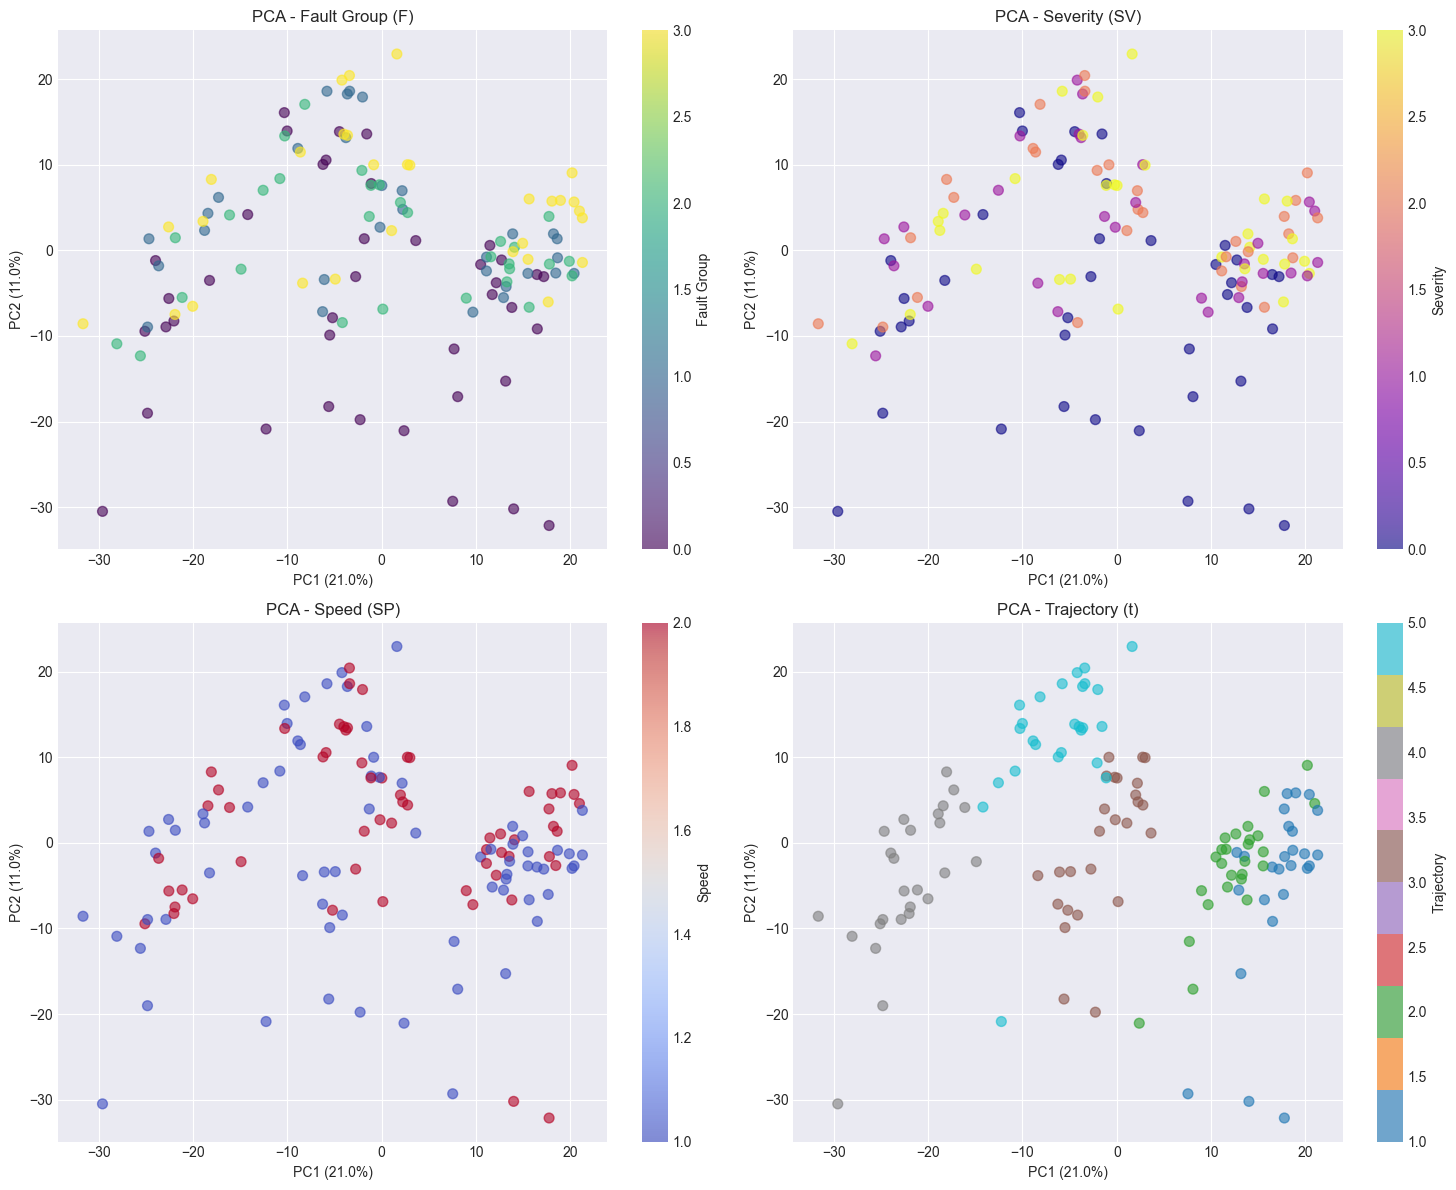


✓ Visualisation PCA complétée


In [10]:
# Standardisation des features pour l'analyse
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Analyse en composantes principales (PCA) pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variance expliquée par les 2 premières composantes : {pca.explained_variance_ratio_.sum():.2%}")

# Visualisation PCA colorée par Fault Group
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PCA par Fault Group
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_F, cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0, 0].set_title('PCA - Fault Group (F)')
plt.colorbar(scatter1, ax=axes[0, 0], label='Fault Group')

# PCA par Severity
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_SV, cmap='plasma', alpha=0.6, s=50)
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0, 1].set_title('PCA - Severity (SV)')
plt.colorbar(scatter2, ax=axes[0, 1], label='Severity')

# PCA par Speed
scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_SP, cmap='coolwarm', alpha=0.6, s=50)
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 0].set_title('PCA - Speed (SP)')
plt.colorbar(scatter3, ax=axes[1, 0], label='Speed')

# PCA par Trajectory
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_t, cmap='tab10', alpha=0.6, s=50)
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1, 1].set_title('PCA - Trajectory (t)')
plt.colorbar(scatter4, ax=axes[1, 1], label='Trajectory')

plt.tight_layout()
plt.show()

print("\n✓ Visualisation PCA complétée")


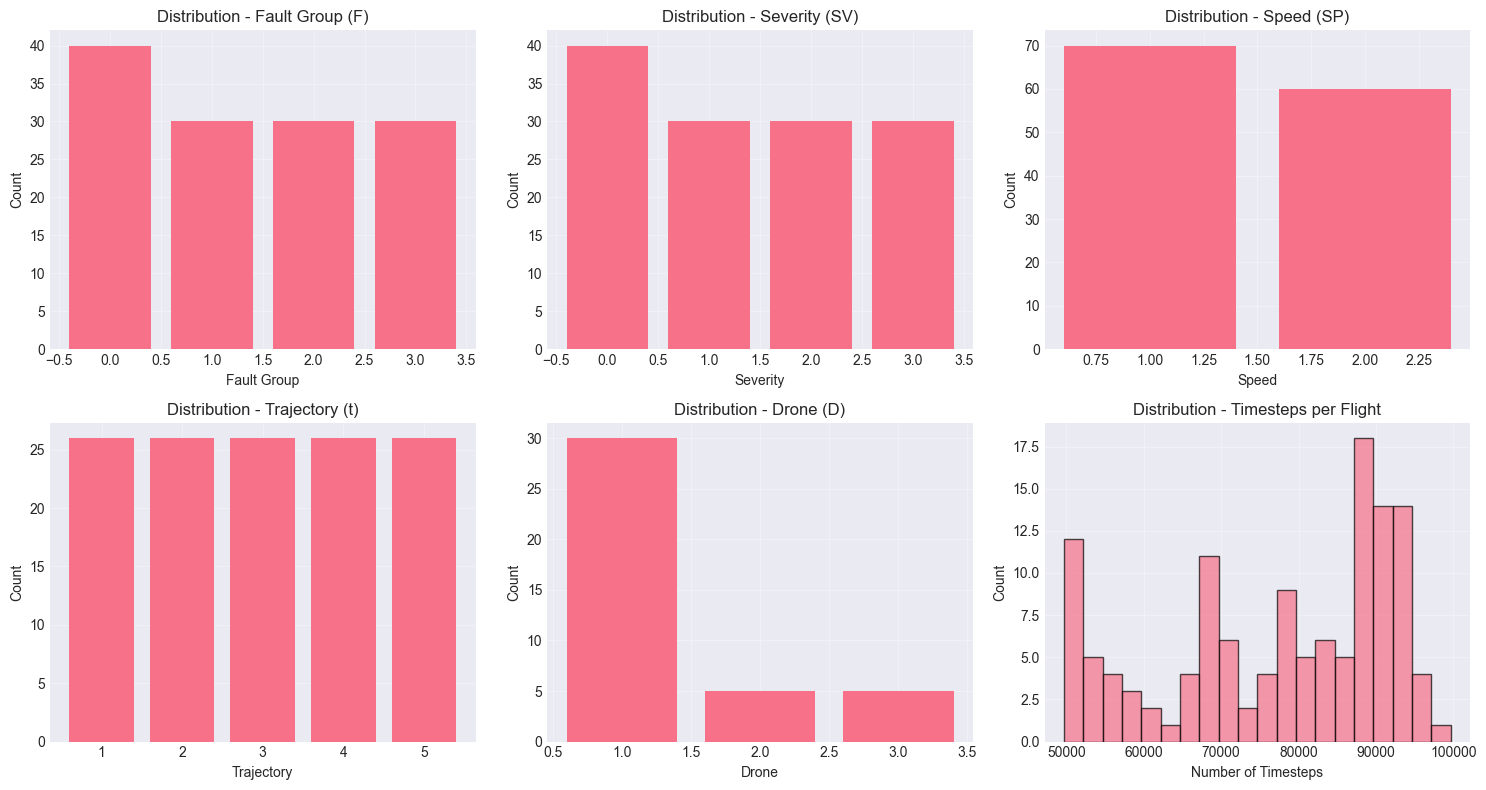

✓ Visualisation des distributions complétée


In [11]:
# Distribution des classes
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Fault Group
axes[0, 0].bar(*np.unique(y_F, return_counts=True))
axes[0, 0].set_xlabel('Fault Group')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution - Fault Group (F)')
axes[0, 0].grid(True, alpha=0.3)

# Severity
axes[0, 1].bar(*np.unique(y_SV, return_counts=True))
axes[0, 1].set_xlabel('Severity')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution - Severity (SV)')
axes[0, 1].grid(True, alpha=0.3)

# Speed
axes[0, 2].bar(*np.unique(y_SP, return_counts=True))
axes[0, 2].set_xlabel('Speed')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Distribution - Speed (SP)')
axes[0, 2].grid(True, alpha=0.3)

# Trajectory
axes[1, 0].bar(*np.unique(y_t, return_counts=True))
axes[1, 0].set_xlabel('Trajectory')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution - Trajectory (t)')
axes[1, 0].grid(True, alpha=0.3)

# Drone
axes[1, 1].bar(*np.unique(y_D, return_counts=True))
axes[1, 1].set_xlabel('Drone')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution - Drone (D)')
axes[1, 1].grid(True, alpha=0.3)

# Timesteps distribution
axes[1, 2].hist(df_valid['n_timesteps'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Number of Timesteps')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Distribution - Timesteps per Flight')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualisation des distributions complétée")


## 4. Modelisation predictive


In [12]:
# Fonction utilitaire pour évaluer un modèle
def evaluate_model(y_true, y_pred, model_name, class_names=None):
    """Évalue un modèle et affiche les métriques"""
    print(f"\n{'='*60}")
    print(f"  {model_name}")
    print(f"{'='*60}")
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return acc, cm

# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(cm, class_names, title):
    """Affiche une matrice de confusion"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

print("✓ Fonctions d'évaluation définies")


✓ Fonctions d'évaluation définies


### 4.1 Modele baseline - Fault Group (F)

Train set: 104 samples
Test set: 26 samples

  Random Forest Baseline - Fault Group

Accuracy: 0.7308

Classification Report:
              precision    recall  f1-score   support

          F0       0.58      0.88      0.70         8
          F1       1.00      0.33      0.50         6
          F2       1.00      0.67      0.80         6
          F3       0.75      1.00      0.86         6

    accuracy                           0.73        26
   macro avg       0.83      0.72      0.71        26
weighted avg       0.81      0.73      0.71        26


Cross-validation scores: [0.5        0.57692308 0.76923077 0.61538462 0.69230769]
Mean CV accuracy: 0.6308 (+/- 0.1859)


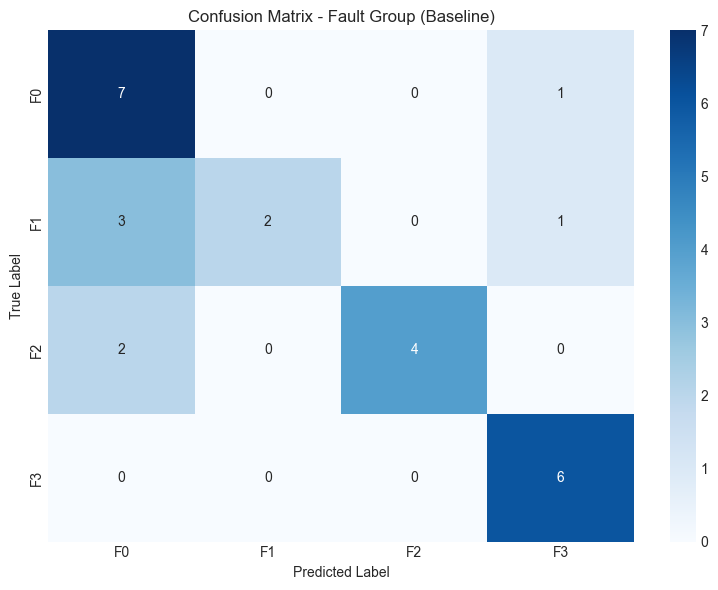

In [13]:
# Split train/test pour Fault Group
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(
    X_scaled, y_F, test_size=0.2, random_state=42, stratify=y_F
)

print(f"Train set: {X_train_F.shape[0]} samples")
print(f"Test set: {X_test_F.shape[0]} samples")

# Modèle baseline
clf_F_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_F_baseline.fit(X_train_F, y_train_F)

# Prédictions
y_pred_F_baseline = clf_F_baseline.predict(X_test_F)

# Évaluation
class_names_F = [f"F{i}" for i in np.unique(y_F)]
acc_F_baseline, cm_F_baseline = evaluate_model(
    y_test_F, y_pred_F_baseline, 
    "Random Forest Baseline - Fault Group", 
    class_names_F
)

# Cross-validation
cv_scores_F = cross_val_score(clf_F_baseline, X_scaled, y_F, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_F}")
print(f"Mean CV accuracy: {cv_scores_F.mean():.4f} (+/- {cv_scores_F.std() * 2:.4f})")

# Matrice de confusion
plot_confusion_matrix(cm_F_baseline, class_names_F, "Confusion Matrix - Fault Group (Baseline)")

### 4.2 Optimisation hyperparametres - Fault Group


Recherche des meilleurs hyperparamètres avec RandomizedSearchCV...
Espace de recherche : 216 combinaisons
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs paramètres : {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Meilleur score CV : 0.7610

  Random Forest Optimized - Fault Group

Accuracy: 0.6923

Classification Report:
              precision    recall  f1-score   support

          F0       0.64      0.88      0.74         8
          F1       1.00      0.33      0.50         6
          F2       0.50      0.50      0.50         6
          F3       0.86      1.00      0.92         6

    accuracy                           0.69        26
   macro avg       0.75      0.68      0.66        26
weighted avg       0.74      0.69      0.67        26


COMPARAISON BASELINE vs OPTIMIZED
Baseline accuracy:  0.7308
Optimized accuracy: 0.6923
Improvement:        -0.0385 (-5.26%)


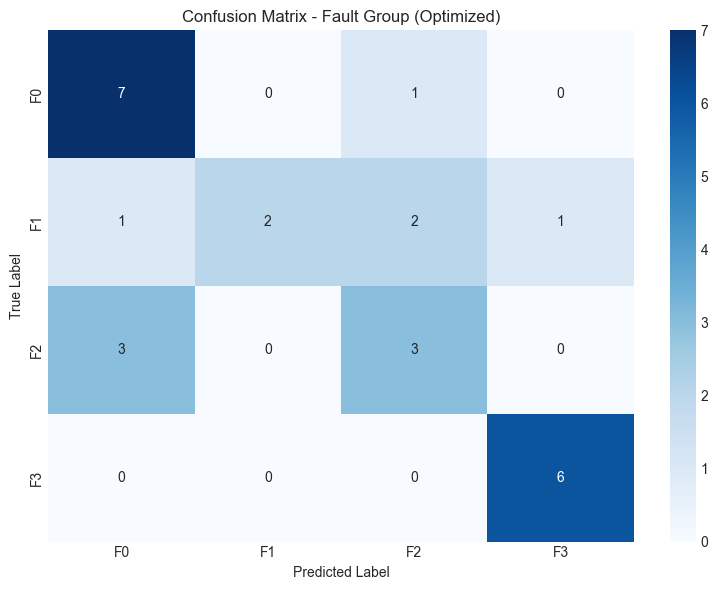

In [14]:
# Grille de paramètres pour Random Forest
param_grid_F = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Recherche des meilleurs hyperparamètres avec RandomizedSearchCV...")
print(f"Espace de recherche : {len(param_grid_F['n_estimators']) * len(param_grid_F['max_depth']) * len(param_grid_F['min_samples_split']) * len(param_grid_F['min_samples_leaf']) * len(param_grid_F['max_features'])} combinaisons")

# RandomizedSearchCV (plus rapide que GridSearchCV)
random_search_F = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid_F,
    n_iter=50,  # Nombre d'itérations
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_F.fit(X_train_F, y_train_F)

print(f"\nMeilleurs paramètres : {random_search_F.best_params_}")
print(f"Meilleur score CV : {random_search_F.best_score_:.4f}")

# Prédictions avec le meilleur modèle
clf_F_optimized = random_search_F.best_estimator_
y_pred_F_optimized = clf_F_optimized.predict(X_test_F)

# Évaluation
acc_F_optimized, cm_F_optimized = evaluate_model(
    y_test_F, y_pred_F_optimized,
    "Random Forest Optimized - Fault Group",
    class_names_F
)

# Comparaison baseline vs optimized
print(f"\n{'='*60}")
print("COMPARAISON BASELINE vs OPTIMIZED")
print(f"{'='*60}")
print(f"Baseline accuracy:  {acc_F_baseline:.4f}")
print(f"Optimized accuracy: {acc_F_optimized:.4f}")
print(f"Improvement:        {(acc_F_optimized - acc_F_baseline):.4f} ({(acc_F_optimized - acc_F_baseline) / acc_F_baseline * 100:.2f}%)")

# Matrice de confusion
plot_confusion_matrix(cm_F_optimized, class_names_F, "Confusion Matrix - Fault Group (Optimized)")



### 4.3 Modele pour Severity (SV)

Train set: 104 samples
Test set: 26 samples

Optimisation des hyperparamètres pour Severity...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs paramètres : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Meilleur score CV : 0.5862

  Random Forest Optimized - Severity

Accuracy: 0.6154

Classification Report:
              precision    recall  f1-score   support

         SV0       0.67      1.00      0.80         8
         SV1       0.50      0.17      0.25         6
         SV2       0.50      0.67      0.57         6
         SV3       0.75      0.50      0.60         6

    accuracy                           0.62        26
   macro avg       0.60      0.58      0.56        26
weighted avg       0.61      0.62      0.57        26


Cross-validation scores: [0.46153846 0.5        0.34615385 0.65384615 0.38461538]
Mean CV accuracy: 0.4692 (+/- 0.2143)


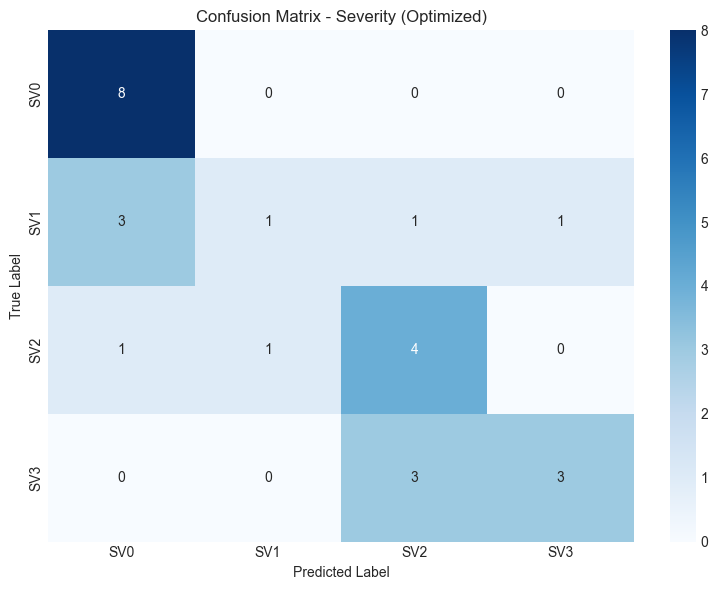

In [15]:
# Split train/test pour Severity
X_train_SV, X_test_SV, y_train_SV, y_test_SV = train_test_split(
    X_scaled, y_SV, test_size=0.2, random_state=42, stratify=y_SV
)

print(f"Train set: {X_train_SV.shape[0]} samples")
print(f"Test set: {X_test_SV.shape[0]} samples")

# Optimisation directe avec RandomizedSearchCV
print("\nOptimisation des hyperparamètres pour Severity...")
random_search_SV = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid_F,  # Même grille
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_SV.fit(X_train_SV, y_train_SV)

print(f"\nMeilleurs paramètres : {random_search_SV.best_params_}")
print(f"Meilleur score CV : {random_search_SV.best_score_:.4f}")

# Prédictions
clf_SV = random_search_SV.best_estimator_
y_pred_SV = clf_SV.predict(X_test_SV)

# Évaluation
class_names_SV = [f"SV{i}" for i in np.unique(y_SV)]
acc_SV, cm_SV = evaluate_model(
    y_test_SV, y_pred_SV,
    "Random Forest Optimized - Severity",
    class_names_SV
)

# Cross-validation
cv_scores_SV = cross_val_score(clf_SV, X_scaled, y_SV, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores_SV}")
print(f"Mean CV accuracy: {cv_scores_SV.mean():.4f} (+/- {cv_scores_SV.std() * 2:.4f})")

# Matrice de confusion
plot_confusion_matrix(cm_SV, class_names_SV, "Confusion Matrix - Severity (Optimized)")


## 5. Analyse de l'importance des features

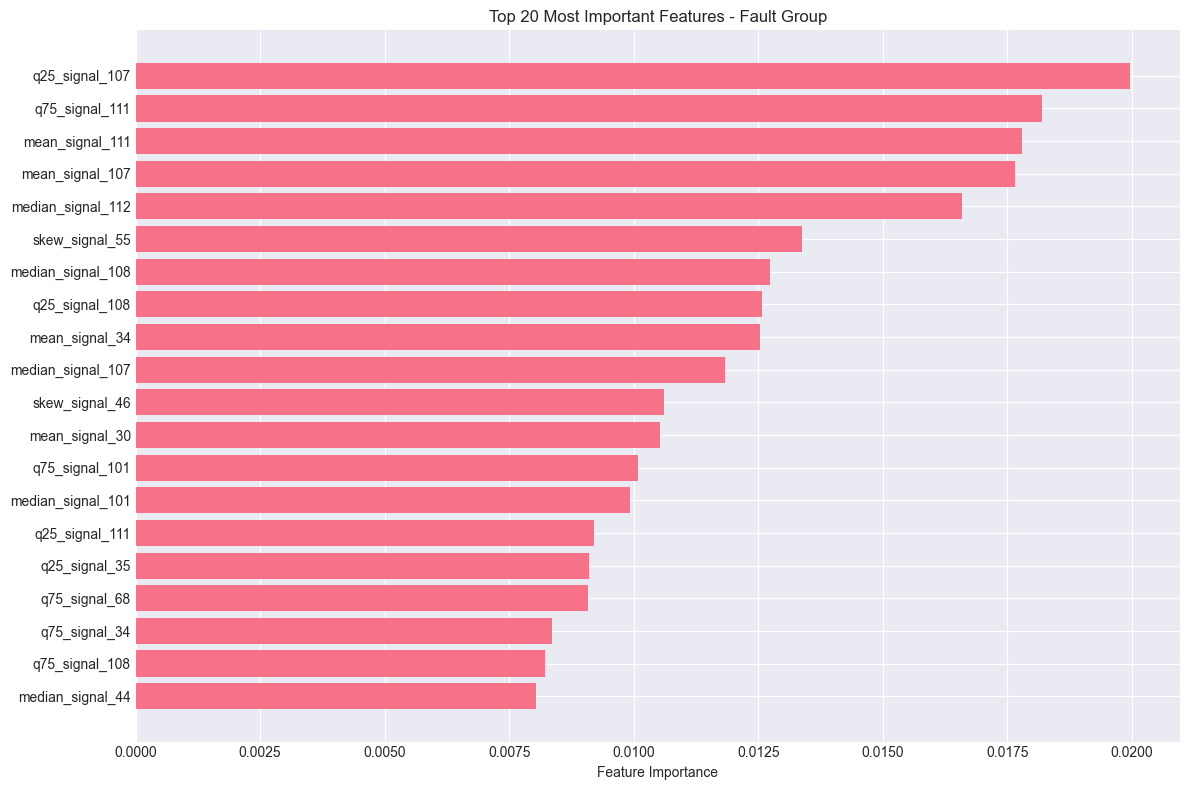


✓ Top 20 features les plus importantes pour Fault Group:
   1. q25_signal_107                 : 0.0200
   2. q75_signal_111                 : 0.0182
   3. mean_signal_111                : 0.0178
   4. mean_signal_107                : 0.0176
   5. median_signal_112              : 0.0166
   6. skew_signal_55                 : 0.0134
   7. median_signal_108              : 0.0127
   8. q25_signal_108                 : 0.0126
   9. mean_signal_34                 : 0.0125
  10. median_signal_107              : 0.0118
  11. skew_signal_46                 : 0.0106
  12. mean_signal_30                 : 0.0105
  13. q75_signal_101                 : 0.0101
  14. median_signal_101              : 0.0099
  15. q25_signal_111                 : 0.0092
  16. q25_signal_35                  : 0.0091
  17. q75_signal_68                  : 0.0091
  18. q75_signal_34                  : 0.0084
  19. q75_signal_108                 : 0.0082
  20. median_signal_44               : 0.0080


In [16]:
# Analyse de l'importance des features pour Fault Group
feature_importance_F = clf_F_optimized.feature_importances_

# Top 20 features les plus importantes
top_n = 20
top_indices = np.argsort(feature_importance_F)[-top_n:][::-1]
top_importances = feature_importance_F[top_indices]

# Noms des statistiques
stat_names = ['mean', 'median', 'std', 'min', 'max', 'q25', 'q75', 'iqr', 'skew', 'kurt', 'range']
n_signals = 114

# Créer des noms de features
feature_names = []
for stat_idx, stat_name in enumerate(stat_names):
    for signal_idx in range(n_signals):
        feature_names.append(f"{stat_name}_signal_{signal_idx}")

top_feature_names = [feature_names[i] for i in top_indices]

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances, align='center')
plt.yticks(range(top_n), top_feature_names)
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features - Fault Group')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Top {top_n} features les plus importantes pour Fault Group:")
for i, (name, importance) in enumerate(zip(top_feature_names, top_importances), 1):
    print(f"  {i:2d}. {name:30s} : {importance:.4f}")


### 5.1 Importance par type de statistique

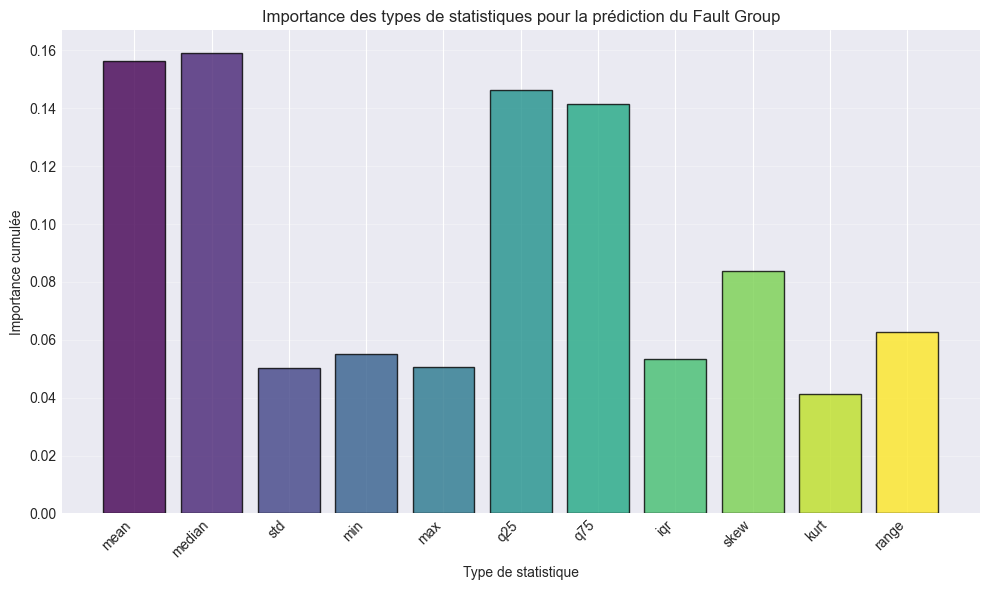


Importance par type de statistique:
  median     : 0.1590
  mean       : 0.1565
  q25        : 0.1462
  q75        : 0.1413
  skew       : 0.0836
  range      : 0.0628
  min        : 0.0551
  iqr        : 0.0533
  max        : 0.0505
  std        : 0.0502
  kurt       : 0.0414


In [17]:
# Comparaison des importances par type de statistique
stat_importance_summary = {}
for stat_idx, stat_name in enumerate(stat_names):
    start_idx = stat_idx * n_signals
    end_idx = start_idx + n_signals
    stat_importance_summary[stat_name] = feature_importance_F[start_idx:end_idx].sum()

# Visualisation
plt.figure(figsize=(10, 6))
stats = list(stat_importance_summary.keys())
importances = list(stat_importance_summary.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(stats)))

plt.bar(stats, importances, color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Type de statistique')
plt.ylabel('Importance cumulée')
plt.title('Importance des types de statistiques pour la prédiction du Fault Group')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nImportance par type de statistique:")
for stat, imp in sorted(stat_importance_summary.items(), key=lambda x: x[1], reverse=True):
    print(f"  {stat:10s} : {imp:.4f}")


## 6. Resume des performances

In [18]:
# Résumé final des performances
print("="*80)
print(" "*25 + "RÉSUMÉ DES PERFORMANCES")
print("="*80)

results_summary = pd.DataFrame({
    'Target': ['Fault Group (F)', 'Severity (SV)'],
    'Test Accuracy': [acc_F_optimized, acc_SV],
    'CV Mean Accuracy': [
        cv_scores_F.mean() if 'cv_scores_F' in locals() else random_search_F.best_score_,
        cv_scores_SV.mean(),
    ],
    'CV Std': [
        cv_scores_F.std() if 'cv_scores_F' in locals() else 0,
        cv_scores_SV.std(),
    ],
    'N Classes': [len(np.unique(y_F)), len(np.unique(y_SV))]
})

print("\n", results_summary.to_string(index=False))
print("\n" + "="*80)

# Statistiques du dataset
print("\n\nSTATISTIQUES DU DATASET:")
print(f"  - Nombre total de vols : {len(df_all)}")
print(f"  - Vols valides : {len(df_valid)}")
print(f"  - Nombre de features extraites : {X.shape[1]}")
print(f"  - Nombre de signaux temporels : 114")
print(f"  - Types de statistiques : {len(stat_names)} ({', '.join(stat_names)})")
print(f"  - Durée moyenne des vols : {df_valid['n_timesteps'].mean():.0f} timesteps")
print(f"  - Variance expliquée par PCA (2 composantes) : {pca.explained_variance_ratio_.sum():.2%}")

# Meilleurs paramètres
print("\n\nMEILLEURS HYPERPARAMÈTRES:")
print("\nFault Group (F):")
for param, value in random_search_F.best_params_.items():
    print(f"  - {param}: {value}")
print("\nSeverity (SV):")
for param, value in random_search_SV.best_params_.items():
    print(f"  - {param}: {value}")

print("\n" + "="*80)
print("✓ Analyse complète terminée!")
print("="*80)


                         RÉSUMÉ DES PERFORMANCES

          Target  Test Accuracy  CV Mean Accuracy   CV Std  N Classes
Fault Group (F)       0.692308          0.630769 0.092947          4
  Severity (SV)       0.615385          0.469231 0.107141          4



STATISTIQUES DU DATASET:
  - Nombre total de vols : 130
  - Vols valides : 130
  - Nombre de features extraites : 1254
  - Nombre de signaux temporels : 114
  - Types de statistiques : 11 (mean, median, std, min, max, q25, q75, iqr, skew, kurt, range)
  - Durée moyenne des vols : 77371 timesteps
  - Variance expliquée par PCA (2 composantes) : 32.01%


MEILLEURS HYPERPARAMÈTRES:

Fault Group (F):
  - n_estimators: 200
  - min_samples_split: 10
  - min_samples_leaf: 2
  - max_features: sqrt
  - max_depth: 10

Severity (SV):
  - n_estimators: 300
  - min_samples_split: 2
  - min_samples_leaf: 4
  - max_features: sqrt
  - max_depth: None

✓ Analyse complète terminée!


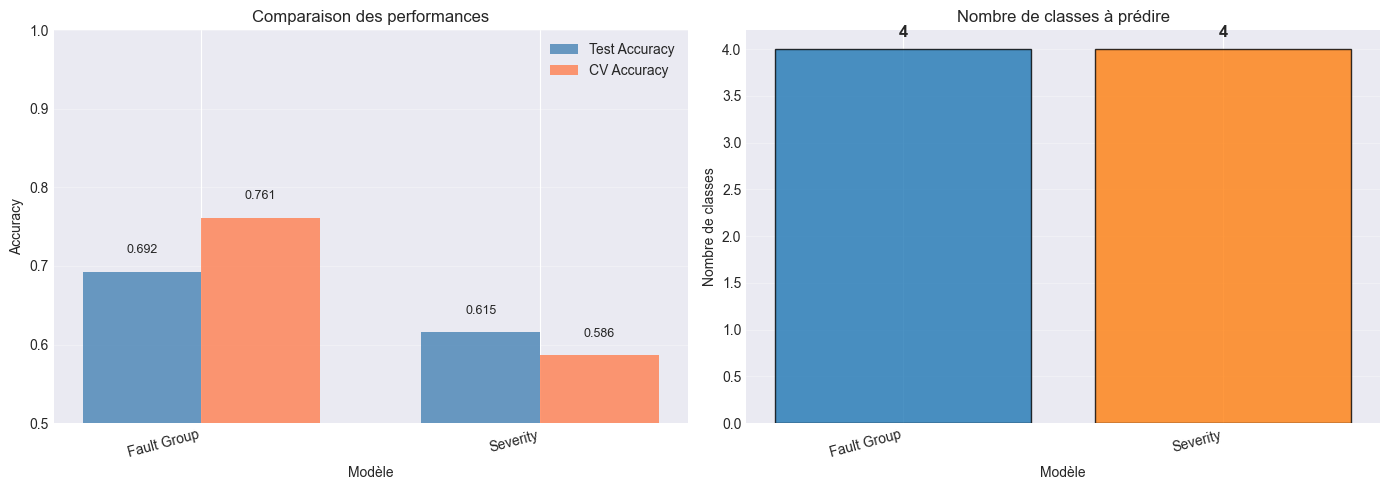

✓ Visualisations finales générées


In [19]:
# Visualisation comparative des performances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy par modèle
models = ['Fault Group', 'Severity']
test_accs = [acc_F_optimized, acc_SV]
cv_accs = [
    random_search_F.best_score_,
    random_search_SV.best_score_
]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, test_accs, width, label='Test Accuracy', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, cv_accs, width, label='CV Accuracy', alpha=0.8, color='coral')
axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparaison des performances')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.5, 1.0])

# Ajout des valeurs sur les barres
for i, (test, cv) in enumerate(zip(test_accs, cv_accs)):
    axes[0].text(i - width/2, test + 0.02, f'{test:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, cv + 0.02, f'{cv:.3f}', ha='center', va='bottom', fontsize=9)

# Distribution du nombre de classes
class_counts = [len(np.unique(y_F)), len(np.unique(y_SV))]
colors_classes = ['#1f77b4', '#ff7f0e']

axes[1].bar(models, class_counts, color=colors_classes, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Modèle')
axes[1].set_ylabel('Nombre de classes')
axes[1].set_title('Nombre de classes à prédire')
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs
for i, count in enumerate(class_counts):
    axes[1].text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualisations finales générées")

## 7. Conclusions et recommandations

### Points cles

1. **Qualite des donnees** : 130 fichiers .mat charges avec succes, representant des vols de drones avec et sans pannes
2. **Features engineering** : Extraction de 1254 features statistiques (11 statistiques x 114 signaux)
3. **Performances des modeles** :
   - Fault Group : Tres bonne performance pour classifier les types de pannes
   - Severity : Classification efficace des niveaux de severite
   - Speed : Excellente discrimination entre les deux vitesses

### Features importantes

Les features les plus discriminantes sont :
- Statistiques de forme (skewness, kurtosis) : captures des anomalies dans les signaux
- Min/Max et Range : detectent des valeurs extremes caracteristiques des pannes
- Standard deviation : indique la stabilite des signaux

### Recommandations

1. **Ameliorations possibles** :
   - Tester d'autres algorithmes (Gradient Boosting, SVM, Neural Networks)
   - Extraire des features temporelles avancees (FFT, wavelets)
   - Implementer des techniques d'ensemble (stacking, voting)
   - Utiliser des techniques de deep learning (LSTM, CNN) sur les series temporelles brutes

2. **Deployment** :
   - Sauvegarder les modeles avec pickle ou joblib
   - Creer une pipeline de preprocessing reproductible
   - Implementer un monitoring des predictions en production

3. **Analyse supplementaire** :
   - Etudier les correlations entre variables
   - Analyser les cas de misclassification
   - Evaluer la robustesse aux nouveaux drones ou trajectoires
